# 02. Embedding Visualizer

Ver. 0.12 から導入された Embedding Visualizer を用いると、を可視化することができます。

Embedding Visualizer を利用するには、 checkpoint に変数を書き込む必要があります。
MNIST の例で見てみます。

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# TensorBoardによる可視化
from google.datalab.ml._tensorboard import TensorBoard
import matplotlib.pyplot as plt

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ラベルファイルと可視化用のsprite画像を用意します。
sprite画像

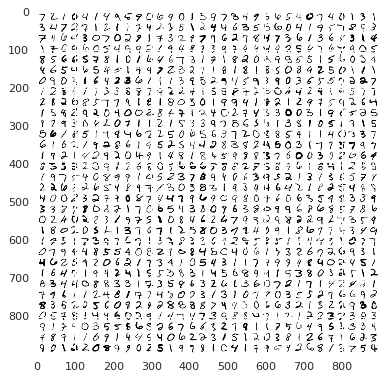

In [5]:
with open('labels.tsv', 'w') as o_:
  for label in np.argmax(mnist.test.labels[:1024], axis=1):
    o_.write('{}\n'.format(label))
    
images = mnist.test.images.reshape(-1, 28, 28)
sprite = np.concatenate([np.concatenate(images[32*row: 32*(row + 1)], 1) for row in range(32)], 0)
plt.imsave('sprite.jpg', sprite)
plt.imshow(sprite)

In [6]:
def conv_layer(input, channels_in, channels_out, name="conv"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([5, 5, channels_in, channels_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="B")
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
  return act

def fc_layer(input, channels_in, channels_out, name="fc"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="B")
    act = tf.nn.relu(tf.matmul(input, w) + b)
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
  return act

In [7]:
def run_mnist(learning_rate, n_fc_layers, n_conv_layers, writer):
  tf.reset_default_graph()
  x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
  y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
  x_image = tf.reshape(x, [-1, 28, 28, 1])
  
  in_ = x_image
  for layer in range(n_conv_layers):
    channels_in = int(in_.get_shape()[-1])
    channels_out = 2**(layer + 1)
    conv = conv_layer(in_, channels_in, channels_out, "conv{}".format(layer))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    in_ = pool
    
  num_elements = in_.get_shape()[1:].num_elements()
  flattened = tf.reshape(in_, [-1, num_elements])
  
  in_ = flattened
  for layer in range(n_fc_layers):
    channels_in = int(in_.get_shape()[-1])
    channels_out = 1024
    fc = fc_layer(in_, channels_in, channels_out, "fc{}".format(layer))
    in_ = fc
  # embedding
  embedding_input = fc
  
  logits = fc_layer(in_, 1024, 10, "fc{}".format(n_fc_layers))
  
  with tf.name_scope("xent"):
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    )
    tf.summary.scalar('xent', cross_entropy)
  with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
  with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('acurracy', accuracy)


  embedding = tf.Variable(tf.zeros([1024, 1024]), name="embedding")
  assignment = embedding.assign(embedding_input)
  
  saver = tf.train.Saver()
  config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
  embedding_config = config.embeddings.add()
  embedding_config.tensor_name = embedding.name
  embedding_config.sprite.image_path = 'sprite.jpg'
  embedding_config.sprite.single_image_dim.extend([28, 28])
  embedding_config.metadata_path = 'labels.tsv'
  tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
    
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    merged_summary = tf.summary.merge_all()
    writer.add_graph(sess.graph)
  
    for i in range(1, 2001):
      batch = mnist.train.next_batch(100)
      if i % 5 == 0:
        s = sess.run(merged_summary, feed_dict={x: batch[0], y: batch[1]})
        writer.add_summary(s, i)
      
      if i%100 == 0:
        train_acurracy = sess.run(accuracy, feed_dict={x: batch[0], y: batch[1]})
        print("step %d, training accuracy %g" % (i, train_acurracy))
        sess.run(assignment, feed_dict={x: mnist.test.images[:1024], y: mnist.test.labels[:1024]})
        saver.save(sess, os.path.join(writer.get_logdir(), "model.ckpt"), i)

      sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

In [ ]:
writer = tf.summary.FileWriter('logs/embedding')
run_mnist(
  learning_rate=1e-4,
  n_fc_layers=1,
  n_conv_layers=2,
  writer=writer
)

step 100, training accuracy 0.4
step 200, training accuracy 0.47
step 300, training accuracy 0.43
step 400, training accuracy 0.62
step 500, training accuracy 0.62
step 600, training accuracy 0.68
step 700, training accuracy 0.72
step 800, training accuracy 0.77
step 900, training accuracy 0.74


In [3]:
pid = TensorBoard.start('logs/embedding')

TensorBoard was started successfully with pid 14571. Click here to access it.

In [55]:
TensorBoard.stop(pid)